# Introduction to Lattice QCD
Last revised: 4-25-2022 by Richard Mueller [rjm6826@psu.edu]

An introduction to lattice QCD based on 'Lattice QCD for Novices' by Peter Lepage.

Submitted as final project for Penn State's PHYS542: Standard Model (4-25-2022).

Revisions:
* v2: Tests if removing the Nth integral improves results.
* v3: Organized code. Added new sections
* v4: Cut non-working code

$$\newcommand{\bra}[1]{\langle{#1}|}$$
$$\newcommand{\ket}[1]{|{#1}\rangle}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
$$\newcommand{\bramket}[3]{\left\langle{#1}|{#2}|{#3}\right\rangle}$$

In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import time

## The Path Integral

Let's look at the Schodinger equation in the time independent case. Time evolution is governed by

$$ i\hbar\partial_{t}\ket{\psi(t)} = H\ket{\psi(t)} \Longrightarrow \ket{\psi(t)} = U(t,t')\ket{\psi(t)} $$
$$ U(t,t') = e^{-iH(t-t')/\hbar} $$

provided that $ t > t' $. $ U(t,t') $ is called the time evolution operator: acting on a position $ \ket{x} $ with it will tell us where a wave at position x at time t will wind up at time t'. The matrix element 

$$ \bramket{x}{U(t,t')}{x'} = \bramket{x}{e^{-iH(t-t')/\hbar}}{x'} \equiv U(x,t;x',t') $$

then tells us the probability of the finding the original propogated wave at x',t'. This function lends $ U(x,t;x',t') $ its name of *propogator*. **Complete knowledge of the propogator, given an initial state, provides complete information about the wave dynamics** (or field dynamics soon... hopefully):

$$
\begin{align}
    \psi(x,t) = \bramket{x}{U(t,t')}{\psi(t')} &= \int dx' \bramket{x}{U(t,t')}{x'} \braket{x'}{\psi(t')} \\
                                               &= \int dx' \bramket{x}{U(t,t')}{x'} \psi(x',t') \\
                                               &= \int dx' U(x,t;x',t') \psi(x',t')
\end{align}
$$

<table>
    <td> <img src="Paths.jpg" alt="Drawing" style="width: 450px;"/> </td>
</table>

It can be shown that the propogator may be partitioned into $n$ time steps $ \delta t $ such that

$$
U(x,t;x',t') = \int \prod_{j=1}^{n} \frac{dp_j}{2\pi\hbar} \prod_{j=1}^{n-1} dx_j e^{-i\delta{t}/\hbar \sum_{j=0}^{n-1}\left[T(p_{j+1}) + V(x_j) - \frac{p_{j+1} (x_{j+1} - x_j)}{\delta{t}} \right] }
$$

The $ \frac{(x_{j+1} - x_j)}{\delta{t}} $ can be identified as the discritized time derivative of $x_{j}$, $\dot{x_{j}}$. Hence the exponent can be identified with the discretized action,

$$ \begin{align}
S = -\delta{t} \sum_{j=0}^{n-1} \left[T(p_{j+1}) + V(x_j) - \frac{p_{j+1} (x_{j+1} - x_j)}{\delta{t}} \right] &= -\delta{t} \sum_{j=0}^{n-1}\left[T(p(t_j)) + V(x(t_j)) - p(t_j)\dot{x}(t_j)\right] \\
                                                                                     &= \delta{t} \sum_{j=0}^{n-1}L(x_j,p_j,t') 
\end{align}
$$

In the continuum limit ($ \delta{t} \rightarrow 0 $ ) we are able to eliminate the integral of $p$ (gaussian):

$$
U(x,t;x',t') = \int D[x] \ e^{i/\hbar S[x]} = \int D[x] \ exp\left[i/\hbar \sum_{j=0}^{n-1}L(x_j,\dot{x}_j,t') \right]
$$

where $ D[x] = \prod_{j=1}^{n-1} dx_j $. Our goal now is to find an efficient way to compute this quantity.

## The Discritized Path Integral


### Representing an arbitrary particle path
A general path $ x(t) $ from $x_i$ to $x_f$ can be arbitrarily long an complex. However, the contribution to the propogator from these paths are actually supressed! We can see this by exploring the action in the *finite difference approximation*.

We approximate the path by specifying $x(t)$ only at the nodes, or sites, of a discretized time line:

$$ t_n = t_i + a*n $$

for $n=0,1,2,...,N$ and where $a$ is the *grid spacing*. The path is represented as a vector of numbers,

$$ x = \left[ x(t_0),x(t_1),...,x(t_N)\right] $$

So, the integral over all paths becomes the integral over all possible values of $x$ at each node:

$$ \int D[x(t)] \longrightarrow A\int_{-\infty}^{\infty} dx_1 dx_2 ... dx_{N-1} $$

Note, the endpoint nodes $x_0,x_N$ are not integrated over, since they are held fixed/defined for all paths. $A$ is the integration normalization factor, which will be useful in the examples which follow. In one dimension, it is $ A = \left( \frac{m}{2\pi a} \right)^{N/2} $.

#### Evaluation of the action: The finite difference approximation
With these tools, our focus becomes

$$ \bramket{x}{e^{-HT}}{x} \approx A\int_{-\infty}^{\infty} dx_1 dx_2 ... dx_{N-1} e^{-S_{lat}[x]} $$

where $ S_{lat}[x] $ is given by

$$ S_{lat}[x] = \sum_{j=1}^{N-1} \left(T(x_j) + V(x_j) \right) = \sum_{j=0}^{N-1} \left( \frac{m}{2a}\left(x_{j+1} - x_j \right)^2 + aV(x_j) \right) $$

Note, when the difference between successive time steps is large, the exponential factor contributes less. Hence, paths which vary quickly are supressed in the integration.

### Application #1: Finding the ground state of a positive valued wavefunction
We first turn our interest to those propogators who time evolve for long periods of time $ T = t - t' $: the self propogator is
$$ \bramket{x}{e^{-HT}}{x} = \sum_{n} \braket{x}{E_n}e^{-E_n T}\braket{E_n}{x} $$

If T is large enough, only the lowest energy term will significantly contribute:
$$ \bramket{x}{e^{-HT}}{x} \longrightarrow^{T\to\infty} e^{-E_0 T} \left|\braket{x}{E_0}\right|^2 $$

Integrating over x provides the ground state energy,
$$ \int dx \bramket{x}{e^{-HT}}{x}  \longrightarrow e^{-E_0 T} $$

The ground state wavefunction is then determined 
$$ \ket{E_0 (x)} = \braket{x}{E_0} = \left[e^{E_0 T} \bramket{x}{e^{-HT}}{x} \right]^\frac{1}{2} $$

Once we fix T,n, we can calculate
* $E_0$ from $ \int dx \bramket{x}{e^{-HT}}{x} $
* $ \ket{E_0 (x)} $ from $ \bramket{x}{e^{-HT}}{x} $

### An example: Ground state of the harmonic oscillator

Lets keep track of our oscillator properties

In [2]:
# Let's keep track of our wavefunction properties
hbar = 1
class oscillator():
    def __init__(self, boundaries, N=8, m=1, k=1, **kwargs):
        self.bdd = boundaries # extent of the wavefunction
        self.N = N # N: time steps
        self.m = m # a: oscillator mass
        self.k = k # k: oscillator strength

        # Grid spacing
        if "a" in kwargs: self.a = kwargs["a"]
        else: self.a = .5

        self.Norm = (self.m/(2*np.pi*self.a))**(self.N/2) # Wave function normalization
        
    # Return the HO potential
    def harmonicV(self,x):
        return .5*self.k*x**2

We'll want to compare our results to the exact solution. Below are some tools for that.

In [3]:
class ExactHarmonicOsc(oscillator):
    def __init__(self, boundaries, N=8, m=1, k=1, **kwargs):
        super().__init__(boundaries, N=8, m=1, k=1, **kwargs)
        self.w = np.sqrt(self.k/self.m)

    # Return the HO ground state
    def HO_GS(self,x):
        amp = ((self.m*self.w)/(np.pi*hbar))**(1/4)
        return amp*np.exp(-self.m*self.w*x**2 / (2*hbar))

    # Return the HO first excited state
    def HO_E1(self,x):
        amp = ((self.m*self.w)/(np.pi*hbar))**(1/4) * np.sqrt(2*self.m*self.w/hbar)*x
        return amp*np.exp(-(self.m*self.w)*x**2 / (2*hbar))

    # Return the HO energy of the nth state
    def HO_E(self,n):
        return (n+1/2)*hbar*self.w

Here are the tools needed for computing the path integral for the harmonic oscillator.

In [4]:
class DiscHarmonicOsc(oscillator):
    def __init__(self, boundaries, N=8, m=1, k=1, **kwargs):
        super().__init__(boundaries, N, m, k, **kwargs)
    
    # Return the action
    def S(self,x):
        KE,PE = 0.0, 0.0
        
        for i in range(len(x)-1):
            KE += self.m/(2*self.a) * (x[i+1] - x[i])**2
            PE += self.a * self.harmonicV(x[i])
            
        return (KE+PE)
    
    # Returns Norm*e^(-S[x])
    def expS(self,*args):
        x = list(args)
        xi = args[-1]
        x.insert(0,xi)
    
        return self.Norm*np.exp(-self.S(x))
    
    # Takes in the wf squared and the pts it was eval. at, then returns the wf and energy
    def makeGS(self,xGrid, result):
        exp_E0T = 2*integrate.simps(y=result, x=xGrid) # *2 because we need the -x contribution too
        E0 = -np.log(exp_E0T)/(self.N*self.a)

        return np.sqrt(result/exp_E0T), E0 
        


We can integrate over the N-2 variables numerically using 'scipy' numerical integration package for vectors, nquad.

In [5]:
d_osc1 = DiscHarmonicOsc(boundaries=[-4, 4], N=5, m=1, k=1)
e_osc1 = ExactHarmonicOsc(boundaries=d_osc1.bdd, N=d_osc1.N, m=d_osc1.m, k=d_osc1.k)

xmax = 2.4
nxpts = 12
xGrid = np.linspace(0, xmax, nxpts)
quadResult = np.zeros_like(xGrid)

start = time.time()

# Evaluate the propogator from x=0 to x=xmax
for i,xi in enumerate(xGrid):
    quadResult[i] = integrate.nquad(func = d_osc1.expS, ranges = (d_osc1.N-2)*[d_osc1.bdd], args = (xi,))[0] #, opts={'points': [-2,2]})[0] #,'epsabs': 1e-3, 'epsrel': 1e-1})[0]
    
end = time.time()
print("Time elapsed: {} s".format(end-start))

Time elapsed: 54.262887716293335 s


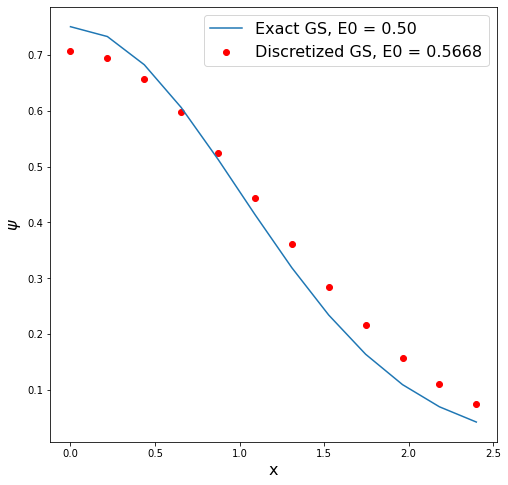

In [6]:
qGS0, qE0 = d_osc1.makeGS(xGrid,quadResult)

fig1,ax1 = plt.subplots(figsize=(8,8))
ax1.scatter(xGrid,qGS0,label="Discretized GS, E0 = {:.4f}".format(qE0), color='red')
ax1.plot(xGrid,e_osc1.HO_GS(xGrid),label="Exact GS, E0 = {:.2f}".format(e_osc1.HO_E(0)))
ax1.set_xlabel("x", fontsize=16)
ax1.set_ylabel(r"$\psi$", fontsize=16)
ax1.legend(fontsize=16)
plt.show()

Not great, it misses the extremes of the wavefunction. Let's try another integration method.

## Monte Carlo Evaluation of Path Integrals

### The Monte Carlo evaluation method

Our goal is to compute

$$ \int_{\vec{x}\in D} f(\vec{x})d\vec{x} $$

Doing some quick rearranging,

$$ \int_{\vec{x}\in D} f(\vec{x})d\vec{x} = \int_{\vec{x}\in D} \frac{f(\vec{x})}{p(\vec{x})} p(\vec{x}) d\vec{x} 
    \equiv \int_{\vec{x}\in D} g(\vec{x}) p(\vec{x}) d\vec{x} = E\left[g(\vec{x})\right] $$
    
In the discretized case, if we have sampled $ N_{cf} $ configurations of the path, this is equivalent to

$$ E\left[g(\vec{x})\right] = \sum^{N_{cf}}_{j=0} \frac{1}{N_{cf}} g(\vec{x}_j) = \sum^{N_{cf}}_{j=0} \frac{1}{N_{cf}} \frac{f(\vec{x}_j)}{p(\vec{x}_j)} $$

We previously identified $ p(\vec{x}) $ as a probability distribution: if we take it to be uniform, and that all variables have the same domain of integration, then all $\vec{x}_j$ have the same probability of occuring within the sample:

$$ \int^{\vec{x}_f}_{\vec{x}_i} f(\vec{x})d\vec{x} \approx \sum^{N_{cf}}_{j=0} \frac{1}{N_{cf}} \frac{f(\vec{x}_j)}{\frac{1}{Area(\vec{x}_f - \vec{x}_i)}} = \sum^{N_{cf}}_{j=0} \frac{Area(\vec{x}_f - \vec{x}_i)}{N_{cf}} f(\vec{x}_j) $$

for finite $ N_{cf} $.


In [7]:
def mc_integrate(func, bounds, N, N_cf = 1000, fixedEnds=True, **kwargs): # https://boyangzhao.github.io/posts/monte-carlo-integration
    x_list = np.zeros((N_cf,N-1))
    
    if fixedEnds:
        x_list[:,N-2] = np.full((N_cf,),kwargs["x0"])
        
    Area=1
    
    # Generate random paths
    for i, (a,b) in enumerate(bounds):
        x_list[:,i] = np.random.uniform(a, b, (N_cf, ))
        Area = Area*(b-a)
    
    y=0
    
    # Calculate f(x)
    for i in range(N_cf):
        if not kwargs:
            y += func(*x_list[i])
        elif fixedEnds:
            y += func(*x_list[i])
        else:
            y += func(kwargs, *x_list[i])
    
    # Compute integral
    integ = Area * y/N_cf
    
    return integ

### Revisited: The harmonic oscillator ground state

Recall, in our evaluation of the harmonic oscillator ground state, we were effectively taking the integral of $ e^{-S[x]} $: so, set $ f(\vec{x}) \equiv e^{-S[x]} $. We can still use the uniform distribution--there is a weight $ e^{-S[x]} $ assigned to each path, so the weights themselves are uniformly distributed across the domain.

We now calculate

$$ \sum^{N_{cf}}_{j=0} \frac{Area(\vec{x}_f - \vec{x}_i)}{N_{cf}} e^{-S[x]} $$

In [8]:
d_osc2 = DiscHarmonicOsc(boundaries=[-4, 4], N=8, m=1, k=1)

mcResult = np.zeros_like(xGrid)

start = time.time()
for i,xi in enumerate(xGrid):
    mcResult[i] = mc_integrate(func=d_osc2.expS, bounds=(d_osc2.N-2)*[d_osc2.bdd], N=d_osc2.N, N_cf=int(5e5), fixedEnds=True, x0=xi)
    
end = time.time()
print("Time elapsed: {} s".format(end-start))

Time elapsed: 81.47866487503052 s


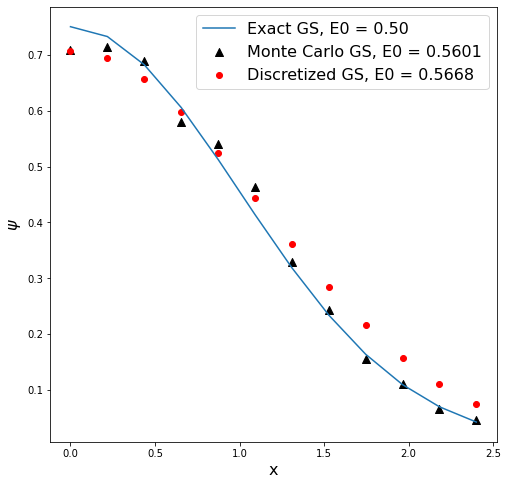

In [9]:
mcGS0, mcE0 = d_osc2.makeGS(xGrid, mcResult)

fig2,ax2 = plt.subplots(figsize=(8,8))
ax2.scatter(xGrid,mcGS0,label="Monte Carlo GS, E0 = {:.4f}".format(mcE0), color='black', marker="^",s=2**6)
ax2.scatter(xGrid,qGS0,label="Discretized GS, E0 = {:.4f}".format(qE0), color='red')
ax2.plot(xGrid,e_osc1.HO_GS(xGrid),label="Exact GS, E0 = {:.2f}".format(e_osc1.HO_E(0)))
ax2.legend(fontsize=16)
ax2.set_xlabel("x", fontsize=16)
ax2.set_ylabel(r"$\psi$", fontsize=16)
plt.show()

The Monte Carlo does a much better job of integrating the extremes

### Application #2: Finding the first excited energy

So, getting the ground state energy was a cool trick. How about higher energies? It looks like we are going to need another trick. Consider the expectation value

$$ \left<x(t_2)x(t_1)\right> \equiv \frac{\int D[x] x(t_2)x(t_1)e^{-S[x]}}{\int D[x] e^{-S[x]}} $$

In order to find the average, we now integrate over all x; that is we now include the two path endpoints in our algorithms. By definition of the time evolution operator, the numerator is

$$ \left<x(t_2)x(t_1)\right> = \int dx \bra{x}e^{-H(t_f - t_2)}\tilde{x}e^{-H(t_2 - t_1)}\tilde{x}e^{-H(t_1 - t_i)}\ket{x} $$

There is a better way to write this. With $ T=t_f - t_i $ & $ t = t_2 - t_1 $,

$$ \left<x(t_2)x(t_1)\right> = \frac{\sum e^{-E_nT}\bra{E_n}\tilde{x}e^{-(H-E_n)t} \tilde{x} \ket{E_n}} {\sum e^{-E_nT}} $$

where we have evaluated $ e^{HT} = e^{E_nT} $ for its eigenvalue. Again, when T>>t and is large, then the ground state dominates, and if t is large (but $ T >> t $ still),

$$
\begin{align} G(t) &\equiv \left<x(t_2)x(t_1)\right> \longrightarrow \bramket{E_0}{\tilde{x}e^{-(H-E_n)t}\tilde{x}}{E_0}
                     & \longrightarrow \left|\bramket{E_0}{\tilde{x}}{E_1}\right|^2 e^{-(E_1 - E_0)t}... 
\end{align} $$
                     
We can manipulate this expression to find $E_1$:

$$ ln G(t) = 2ln(\bramket{E_0}{\tilde{x}}{E_1} - (E_1 - E_0)t $$
$$ ln \left(G(t)/G(t+a)\right) \longrightarrow (E_1 - E_0)a $$

In [10]:
# Calculate the first excited state energy
def make1E(self,resultn):
    dE = np.log(resultn[:-2]/resultn[1:-1])/self.a    
    return dE

setattr(DiscHarmonicOsc, "make1E", make1E)

### The Metropolis Algorithm: A computational speed-up

What if we could create some specialized random-vector generator that would create our Monte-Carlo set of paths that *already has* the probability weighting $ P[x] = e^{-S[x]} $ included in it? That way, we wouldn't have to create so many paths and weigh them afterwards!

The Metropolis Algorithm begins with a random path $ x_0 $. $x_0$ is modified at each lattice point, creating a new (or *updated*) path $ x_1 $. We want to do something with $ \Delta S $....

The algorithm steps are as follows:
1. Initialize the first path $ x_0 $ to all 0's. Set a 
2. Update the path: for the $ j^{th} $ lattice site on the $ n^{th} $ path $ x^n_j $,
     1. Generate a random number $ \delta $ in some finite range, and consider the same path with $ x^n_j \rightarrow x^n_j + \delta $; 
     2. If the action is reduced $ \Delta S < 0 $ between these two paths, keep the new $ x_j $ and proceed to the next value of j.
     3. Generate a randome number $0 \leq \eta \leq 1$. If the action is increased $ \Delta S > 0 $ between these two paths *and* if $ e^{-\Delta S} > \eta $, keep the new $ x_j $. Otherwise, restore the old value and move on to the next lattice point.
3. Keep the path. Repeat the update N times
4. Average the paths to get the estimate
        
The Metropolis Algorithm is 'not always the best', and there are a couple of optimization techniques we will use. 
1. Thinning out correlated paths
    1. Adjusting epsilon - it has been advised that one keeps track of the "success" rate of the update step (2) and adjust epsilon so that it has about 50% success. This has already been tweaked to the value of 1.4.
2. Thermalizing the lattice
    1. The initial few paths will clearly be highly correlated--there is a significant chance that some points on the path don't even change from 0. To this end, we throw away some significant number of early paths. Tossing out the first ~100 paths works well.

In [11]:
# Calculates the difference in action that comes from site x[n]
def dS_n(self,x,n):
    KE = self.m/self.a * x[n]*(x[n] - x[(n+1)%self.N] - x[(n-1)%self.N])
    PE = self.a * self.harmonicV(x[n])
    
    return KE+PE

setattr(DiscHarmonicOsc, "dS_n", dS_n)

# Metropolis ath update algorithm
def maUpdate(x, osc, eps):
    for n in range(osc.N-1):
        dS_old = osc.dS_n(x,n)
        xi = np.random.uniform(-eps, eps)

        x[n] += xi
        
        dS_new = osc.dS_n(x, n)
        
        dS = dS_new - dS_old
        
        if dS > 0 and np.exp(-dS) < np.random.uniform(0,1): ################
            x[n] -= xi

# Metropolis integration
def maMC_integrate(func, osc, eps, N_cor, N_cf, fixedEnds=False, **kwargs):
    # Intialize
    x = np.zeros(osc.N)
    f_list = np.zeros((osc.N, N_cf))
    avg_f = np.zeros(osc.N)
    
    # Throw out the first ~100 correlated paths
    for j in range(5*N_cor):
        maUpdate(x,osc,eps)

    # Start to generate paths which will contribute to the average
    for alpha in range(N_cf):
        # Space out path samples by ~20 updates
        for j in range(N_cor):
            maUpdate(x,osc,eps)
        
        # Generate path to use
        if not kwargs:
            avg_f += func(*x)
        elif fixedEnds:
            avg_f += func(*x)
        else:
            f_list[:,alpha] += func(*x)
    
    # Average over N_cf paths
    if not kwargs:
        return avg_f[0]/N_cf/osc.N
        
    else:  
        for n in range(osc.N-1):
            for alpha in range(N_cf):
                avg_f[n] += f_list[n][alpha] #mid_f[n][alpha]

        avg_f = avg_f/N_cf/osc.N

        return avg_f


These path integrals averages $ \left<\Gamma [x] \right> $ of arbitrary functionals $ \Gamma [x] $ can be used to compute any physical property of the excited states. Note

$$ \left<\Gamma[x]\right> = \frac{\int D[x] \Gamma[x]e^{-S[x]}}{\int D[x] e^{-S[x]}} $$

We call the Monte Carlo uncertainty $ \sigma_{\bar{\Gamma}} $. This will never be zero, since the number of paths will never be infinite, and is a potential source of error estimated as

$$ \sigma^2_{\bar{\Gamma}} \approx \frac{1}{N} \left[ \frac{1}{N} \sum^{N}_{\alpha=1} \Gamma^2 [x^{\alpha}] - \bar{\Gamma}^2 \right] 
                            \longrightarrow \frac{\left<\Gamma^2 \right> - \left<\Gamma\right>^2 }{N} $$
                            
For N large, the statistical uncertainties are supposed to vanish.

### Revisited: The harmonic oscillator

We can test this new method out by

1. Finding the expectation value of H for low energy contributions, $ \left< H \right> $
2. Finding $ \Delta(E_1 - E_0) $ as mentioned before

In [12]:
def H(self,*xx):
    KE,PE = 0.0, 0.0
    x = list(xx)

    for i in range(len(x)-1):
        KE += self.m/(2*self.a) * (x[i+1] - x[i])**2
        PE += self.a * self.harmonicV(x[i])

    return (KE+PE)

def G_ma(self, *xx):
    x = list(xx)
    g = np.zeros(len(x))

    for n in range(len(x)-1):
        for i in range(len(x)-1):
            g[n] += x[i]*x[(i+n)%self.N] # it's now periodic, I guess
        
    return g

setattr(DiscHarmonicOsc, "H", H)
setattr(DiscHarmonicOsc, "G_ma", G_ma)

In [13]:
N_cor = 20 # Number of paths to generate, then skip in order to thermalize
N_cf = 3500  # Number of paths to generate after thermalization
eps = 1.4 # Path rejecting parameter, optimized before hand

1. Finding the expectation value of H for low energy contributions, $ \left< H \right> $

In [14]:
d_osc2 = DiscHarmonicOsc(boundaries=[-4, 4], N=20, m=1, k=1)

start = time.time()
maMC_E0 = maMC_integrate(d_osc2.H, d_osc2, eps, N_cor, N_cf, fixedEnds=False)
end = time.time()
print("Time elapsed: {} s".format(end-start))

print("Ground state energy: {:.4f}".format(maMC_E0))

Time elapsed: 12.041043996810913 s
Ground state energy: 0.4591


2. Finding $ \Delta(E_1 - E_0) $ as mentioned before,
$$ ln \left(G(t)/G(t+a)\right) \longrightarrow (E_1 - E_0)a $$

In [15]:
d_osc2 = DiscHarmonicOsc(boundaries=[-4, 4], N=30, m=1, k=1)

start = time.time()
avg_G = maMC_integrate(d_osc2.G_ma, d_osc2, eps, N_cor, 2*N_cf, fixedEnds=False, n=8)
end = time.time()
print("Time elapsed: {} s".format(end-start))

avg_dEm = d_osc2.make1E(avg_G)

Time elapsed: 40.688790798187256 s


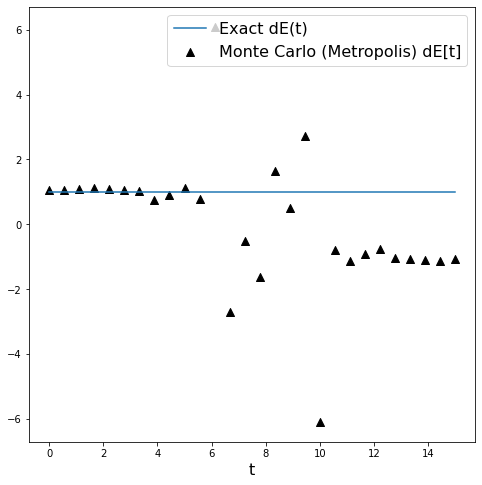

In [16]:
fig4,ax4 = plt.subplots(figsize=(8,8))
nspace = np.linspace(0, d_osc2.a*(d_osc2.N), d_osc2.N-2) #0, np.ceil((d_osc2.N-2)/d_osc2.a),(d_osc2.N-2))
ax4.scatter(nspace, avg_dEm, label="Monte Carlo (Metropolis) dE[t]", color='black', marker="^",s=2**6)
ax4.plot(nspace,len(nspace)*[e_osc1.HO_E(1)-e_osc1.HO_E(0)], label="Exact dE(t)")
ax4.legend(fontsize=16)
ax4.set_xlabel("t", fontsize=16)

plt.show()

True to prediction, this is only any good if the time between propogation (n a) is much shorter than the total number of time steps (N a). Note that we have chosen periodic boundary conditions, which is why the plot appears to flip (the log inverts).

### Statistical Errors (skip)

There are always statistical errors that vanish only in the limit where infinitely many configurations are employed: $ N_{cf} \rightarrow \infty $. The crude way to get the statistical uncertainty on our expectation value is to run the calculation many times, and deduce the uncertainty from those trials. The main source of computational expense comes from the generation of new random numbers.

This is where the bootstrap procedure comes in. Given $ N_{cf} $ measurements of an expectation value $ \bar{E} $, we can construct a "bootstrap copy" of the ensemble by selectring frandom $ \bar{E} ^ \alpha $'s at random from the original ensemble taking $ N_{cf} $ random samples from our $ N_{cf} $ paths: the bootstrap copy is allowed to contain duplicates. This new ensemble can be averaged to obtain a new estimate for $ \bar{E} $. By repeating this procedure many times, we can generate a distribution of $ \bar{E} $'s with the same distribution of that generated by the original Monte Carlo method!


Missing: Section on binning

Missing: code realization

## Field theory on a Lattice

From quantum mechanics to field theory, the analogous quantity of interest turns from $ x(t) \longrightarrow $ to fields $ \phi(x) $ or $ A_u(x) $ where x now represents the four position $ x = (t, \vec{x}) $. The analogy to the QM ground state is the vacuum state $ \ket{0} $: the analogous excited states created by $ \phi^{m} \ket{0} $ with $ m \in N $, and they now correspond to $ r $ particles.

In the lattice approximation, both space and time are discrete. The nodes, or **sites**, of the grid are separated by lattice spacing a, with total side length L. The lines which join sites along basis vectors are called **links**. The quantum field can be specified by its values at the grid sites

<!-- ![alt](FieldOnALattice_1.png) | ![alt](LatticeVocab.png) -->

<table>
    <td> <img src="LatticeVocab.png" alt="Drawing" style="width: 250px;"/> </td>
</table>

A field configuration is described by the set of its values on grid sites $ \phi(x_j), \forall \ x_j \in grid $. The path integral generalizes as 

$$ \left<\Gamma[\phi]\right> \equiv \frac{1}{Z} \int e^{-S[\phi]} \Gamma[\phi] \ \prod_{x_j \in grid} d\phi(x_j) $$

where $ Z $ is the normalization 

$$ \int e^{-S[\phi]} \prod_{x_j \in grid} d\phi(x_j) $$

We will get to the meaning of $ S[\phi] $ soon. With this formulism, we study excitations of the field theory with operators like

$$ \Gamma(t) \equiv \frac{1}{\sqrt{N}} \sum_{\vec{x}_j} \phi(\vec{x}_j,t) $$

The sum over $ N $ spatial $ \vec{x}_j $'s enforces zero three-momentum (?). The analagous excited states, being linked to particle creation, are actually the energies of the particles themselves: our analogy continues

$$ \left<\Gamma(t)\Gamma(0)\right> \longrightarrow ^{t large} \left| \bramket{0}{\Gamma(0)}{\phi: \vec{p} = \vec{0}} \right| ^2 e^{-m_\phi t} $$

This is a $ \phi $ 1-particle state with 0 three-momentum and mass $ m_\phi $.

### Coarse discretization of lattices

Early enthusiasm for computational approaches to QCD where cooled by sobering estimates of the computational expense of numerically evaluating path integrals. Today, these problems have been impressively (but not absolutely mitigated). One reason is obviously the exponential increase in computational power. The other is actually... idk how to condense

$$ cost \approx \left(\frac{L}{a}\right)^4 \frac{1}{a} \frac{1}{m^2_\pi a} $$

In field theory, the field-momentum is a little more abract, namely $ \left(\partial_\mu \phi \right)^2 \neq \partial^2_\mu \phi $. We need an expression for the RHS of the previous equation: try

$$ \frac{\partial\phi(x)}{\partial x} = \frac{1}{a} \left(\phi_{x} - \phi_{x-a} \right) + \vartheta(a) $$
$$ \frac{\partial^2 \phi(x)}{\partial x^2} = \frac{1}{a^2} \left[\left(\phi(x+a) - \phi(x)\right) - \left(\phi(x) - \phi(x-a)\right) \right] + \vartheta(a^2) = \frac{1}{a^2} \left[\phi(x-a) + \phi(x+a) - 2\phi(x)\right] + \vartheta(a^2) $$

There is one better, though I offer no explanation. Defining the previous quantity as

$$ \Delta^{(2)}_x \phi(x) = \frac{1}{a^2} \left[\phi(x-a) + \phi(x+a) - 2\phi(x)\right] $$

we will be using

$$ \frac{\partial^2 \phi(x_j)}{\partial x^2} \equiv \Delta^{(2)}_{x_j} \phi(x_j) - \frac{a^2}{12} (\Delta^{(2)}_{x_j} \phi(x))^2 \phi(x_j) + \vartheta(a^4) $$

going forward. This is claimed to be accurate to a few percent even when acting on structures in $ \phi(x) $ that are as small as 4-5 lattice spacings across [?]. The naive expectation is that investigating hadrons will require lattice spacings of only ~.2 of their diameter. However, consideration must be given to the shortest wavelengths we are able to model on a lattice spaced like that. 

The minimum oscillation we are able to model has wavelength $ \lambda_{min} = 2a $--the oscillation finishes at an adjacent site. This means that gluons and quarks with momenta $ p = 2\pi/\lambda $ larger than $ 2\pi/\lambda_{min} = \pi/a $ are excluded from our calculations, acting as a filter or an ultraviolet cutoff. For noisy nonlinear interacting quantum field theories, ultraviolet modes strongly affect lower energy states. In lattice field theory lingo, these extra terms are called **tadpole contributions**.

Luckily, smart people have figured out how to mimic the effect on lower energy states. It's done by changing, or 'renormalizing', the parameters in the discretized theory and by adding new local interactions. As an example, the discretized kinetic Lagrangian for an interacting scalar theory is

$$ \sum_\mu \frac{1}{2} \phi^\dagger \partial_{\mu^2} \phi \longrightarrow \sum_\mu \frac{1}{2} \left( \phi^\dagger \Delta^{(2)}_x \phi(x) \phi + a^2 c (\phi^\dagger \Delta^{(2)}_x \phi(x))^2 \right) $$

where c is a parameter with two parts: $ \frac{-1}{12} $ from our numerical derivative, and an additional renormalization due to cutoff. The later is typically context dependent and must be computed using QFT. Since QCD is perturbative at high energies, we can write $c$ for it as a function of the running strong coupling

$$ c = \frac{-1}{12} + c_1 \alpha_s(\pi/a) + c_2 \alpha^2_s(\pi/a) \ + \ ... $$

According to Lepage (2005), this perturbative approach works for lattice spacings smaller than 0.05-0.1 fm.


### A test of the new action

In [17]:
# Returns second derivative in the discrete approximation (old)
def Delta(self, x, i):
    return (1/self.a**2) * (x[(i+1)%self.N] - 2*x[i] + x[(i-1)%self.N])

# Return the "improved" action
def improvedS(self,x):
    KE,PE = 0.0, 0.0
    Delt = np.zeros(len(x))
    Deltasq = np.zeros(len(x))

    for i in range(len(x)-1):
        Delt[i] = self.Delta(x,i)
        
    for i in range(len(x)-1):
        Deltasq[i] = self.Delta(Delt, i)
        KE += self.a * (self.m/2 * x[i]*(Delt[i] - self.a**2 * Deltasq[i]/12 ))
        PE += self.a**2 * self.harmonicV(x[i])

    return (-KE+PE)

# Returns Norm*e^(-S[x])
def improvedExpS(self,*args):
        x = list(args)
        xi = args[-1]
        x.insert(0,xi)
        # print(x)
    
        return self.Norm*np.exp(-self.improvedS(x))
    
setattr(DiscHarmonicOsc, "improvedS", improvedS)
setattr(DiscHarmonicOsc, "improvedExpS", improvedExpS)
setattr(DiscHarmonicOsc, "Delta", Delta)

In [18]:
d_osc3 = DiscHarmonicOsc(boundaries=[-4, 4], N=8, m=1, k=1)

mcResultv2 = np.zeros_like(xGrid)

start = time.time()
for i,xi in enumerate(xGrid):
    mcResultv2[i] = mc_integrate(d_osc3.improvedExpS, bounds=(d_osc3.N-2)*[d_osc3.bdd], N=d_osc3.N, N_cf=int(1e5), fixedEnds=True, x0=xi)
    
end = time.time()
print("Time elapsed: {} s".format(end-start))

Time elapsed: 39.13310480117798 s


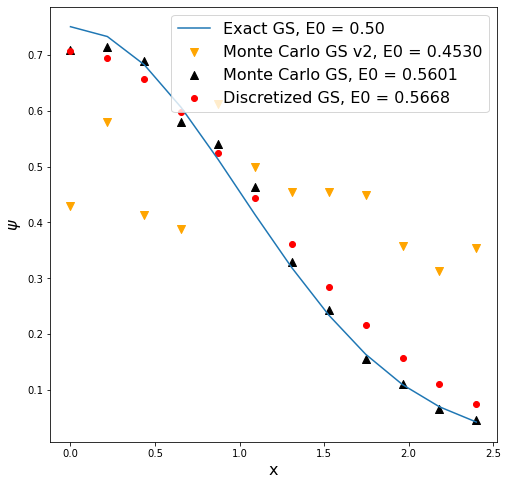

In [19]:
mcGS0v2, mcE0v2 = d_osc3.makeGS(xGrid, mcResultv2)

fig5,ax5 = plt.subplots(figsize=(8,8))
ax5.scatter(xGrid,mcGS0v2,label="Monte Carlo GS v2, E0 = {:.4f}".format(mcE0v2), color='orange', marker="v",s=2**6)
ax5.scatter(xGrid,mcGS0,label="Monte Carlo GS, E0 = {:.4f}".format(mcE0), color='black', marker="^",s=2**6)
ax5.scatter(xGrid,qGS0,label="Discretized GS, E0 = {:.4f}".format(qE0), color='red')
ax5.plot(xGrid,e_osc1.HO_GS(xGrid),label="Exact GS, E0 = {:.2f}".format(e_osc1.HO_E(0)))
ax5.legend(fontsize=16)
ax5.set_xlabel("x", fontsize=16)
ax5.set_ylabel(r"$\psi$", fontsize=16)
plt.show()

As we can see, there seems to be some kind of mistake.

## QCD on a Lattice

### Building a gauge invariant lattice theory

The continuum action in QCD is given by

$$ S = \int d^4 x \frac{1}{2} \sum_{\mu,\nu} F^2_{\mu \nu} (x) $$

where x is the four position and 

$$ F_{\mu \nu} = \partial_\mu A_\nu - \partial_\nu A_\mu + i g [A_\mu, A_\nu] $$

is the field tensor on field $ A $ with coupling strength $ g $. QCD is an approximate SU(3) gauge theory, invariant under transformations

$$ F_{\mu \nu} \longrightarrow \Omega(x) F_{\mu \nu} \Omega(x) $$

The theory on a lattice departs from the work so far in that the field is **not specified on the lattice sites**. Rather, it is specified on the links. The *link variable* which specifies the link joining site $x$ to $x+a\hat{\mu}$ is

$$ U_\mu (x) \equiv P \ exp(-i\int^{x+a\hat{\mu}}_x g A \cdot dy) $$

The $ U_\mu $'s are gauge invariant and tranform via 

$$ U_\mu (x) \longrightarrow \Omega(x) U_\mu (x) \Omega(x+a\hat{\mu}) $$

Pictorally, we can see the this matrix's conjugate represents a link in the opposite direction (the sign of the integral is reverse),

<table>
    <td> <img src="Link1.png" alt="Drawing" style="width: 250px;"/> </td><td> <img src="Link2.png" alt="Drawing" style="width: 250px;"/> </td>
</table>

#### Important definition: The Wilson Loop function

For any closed path $ C $ built of links on the lattice we can define the Wilson loop function,

$$ W(C) \equiv \frac{1}{3} Tr P e^{-i \oint_C g A \cdot dx } $$

This can be computed from the path ordered product of $ U_\mu $'s and $ U^\dagger_\mu$'s. The following loop gives the intuition, combined with previous definitions, that

$$ W(C) \equiv \frac{1}{3} Tr (U_\mu(x)U_\nu(x+a\hat{\mu})...U^\dagger_\nu(x)) $$

<table>
    <td> <img src="Wilson.png" alt="Drawing" style="width: 250px;"/> </td>
</table>

The simplest Wilson loop function is that of a $ \mu \times \nu $ square: this is called the *plaquette operator*. For a field slowly varying over nearby lattice links, it can be shown that

$$ P_{\mu\nu} \approx \frac{1}{3} Re \ Tr \left[ 1 - i\left(a^2 F_{\mu\nu}(x_0) + \frac{a^4}{24}(D^2_\mu + D^2_\nu)F_{\mu\nu}|_{x_0} \right) - \frac{1}{2}\left(a^2 F_{\mu\nu}(x_0) + \frac{a^4}{24}(D^2_\mu + D^2_\nu)F_{\mu\nu}|_{x_0} \right)^2 \right] $$

Making the connection with covariant derivatives $ D $ and the action, we find the traditional *Wilson action* for gluons

$$
    S_{Wil} = \beta \sum_{x,\mu > \nu} (1 - P_{\mu\nu}(x)) 
            = \int d^4 x \sum_{\mu,\nu} \left[ \frac{1}{2} Tr F^2_{\mu\nu} + \frac{a^2}{24} Tr F_{\mu\nu}(D^2_\mu + D^2_\nu)F_{\mu\nu} + ... \right]
  $$
  
which, we see is equivalent to the classical action to $ \vartheta(a^2) $. However, we can do better. We can actually cancel the term second order in $a$ by adding in a couple *rectangle operators*, another special case of the Wilson operator, which have the expansion

<table>
    <td> <img src="Rectangle.png" alt="Drawing" style="width: 250px;"/> </td>
</table>
$$ R_{\mu\nu} = 1 - \frac{4}{6} a^4 Tr (gF_{\mu\nu})^2 - \frac{4}{72}a^6 Tr(gF_{\mu\nu}(4D^2_\mu + D^2_\nu)gF_{\mu\nu} - ... $$

$$ \longrightarrow S_{Wil} = -\beta \sum_{x,\mu > \nu} \frac{5}{3}P_{\mu\nu}(x) - \frac{R_{\mu\nu} - R_{\nu\mu}}{12} + const. 
            = \int d^4 x \sum_{\mu,\nu} \frac{1}{2} Tr F^2_{\mu\nu} + \vartheta(a^4) $$

### Quantum Gluons: Quantum effects in perturbation theory

Similar to the improved path integral action covered earlier, there are ways to mitigate the higher order contributions to the action for quantum gluons. These likewise can be realized as a perturbative terms. I present without proof that with

<table>
    <td> <img src="Circle.png" alt="Drawing" style="width: 200px;"/> </td>
</table>

$$ S_{Wil} = -\beta \sum_{x,\mu > \nu} \frac{5}{3}P_{\mu\nu}(x) - r_g\frac{R_{\mu\nu} - R_{\nu\mu}}{12u_0^6} + c_g \beta  \sum_{x,\mu > \nu > \sigma} \frac{C_{\mu\nu\sigma}}{u_0^6} $$

with $ r_g = 1 + .48 \alpha_s(\pi/a) $, $ c_g = .055 \alpha_s (\pi/a) $, is exact to order $ \vartheta(a^2\alpha_s^2, a^4) $.

### Monte Carlo Evaluation of Gluonic Path Integrals

The main difference in methodology in the Gluonic case:
1. The links are now matrices. To update them, they have to be multiplied by another matrix. So, 

$$ U_\mu \longrightarrow M U_\mu, \ \ M \approx 1 + \epsilon H $$

with $ H $ a hermitean matrix with entries & $ \epsilon $ less than unity.

2. The Metropolis algorithm now needs to thermalize links with their surroundings, rather than with the whole lattice. The thermalization step now takes place many more times.

### A first application of Lattice QCD

was going to be to calculate the potential energy between a static quark and static antiquark, but the code is hard and I don't have time. But in this case, propogation is described by the Green's function described by

$$ (D_t - \frac{\vec{D}^2}{2M}) G(x) = \delta^4(x) $$

where $ D $ is again the covariant derivative $ D_\mu = \partial_\mu -igA_\mu(x) $. In the heavy quark limit,

$$ G_\infty(\vec{x},t) = \left[Pe^{-i\oint^t_0 gA_0 (\vec{x},t)dt}\right]^\dagger \delta(\vec{x}) $$

On the lattice, this becomes

$$ G_\infty(\vec{x},t) = U^\dagger_t(\vec x, t-a) U^\dagger_t(\vec x, t-2a) ... U^\dagger_t(\vec x, 0) $$

Propogation of the static antiquark is described by $ G^\dagger_\infty(\vec{x},t) $. For a quark-antiquark pair a distance $ r $ apart, the functional whose low-energy expectation value we now must obtain is

$$ \left<\Gamma(t)\right> \approx \bramket{0}{\Gamma(t)}{0} = W(r,t) $$
<table>
    <td> <img src="q_antiq_gamma.png" alt="Drawing" style="width: 250px;"/> </td>
</table>
$$ \longrightarrow const \ e^{V(r)t} $$

for large t. As before in this limit,

$$ W(r,t)/W(r,t+a) \longrightarrow aV(r) $$

#### Another computational speedup: Smeared links

## References

[1] Lepage, G. Peter. "Lattice QCD for Novices", 2005, Cornell University

[2] Garcia, Erick. "Path Integral Formulation of Quantum Mechanics", 2021, PSU